<a href="https://colab.research.google.com/github/SalimZ04/UAV_MCV/blob/main/problemCVRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L’objectif du CVRP est de minimiser le coût total, c-à-d la somme des distances ou des temps de parcours des tournées, tout en respectant la contrainte de capacité des véhicules : la quantité de marchandises livrées sur une tournée ne doit pas dépasser la capacité du véhicule qui l’assure

 La figure au dessous, représente un exemple de problème 1 de VRP avec 20 clients, résolu avec 4 véhicules.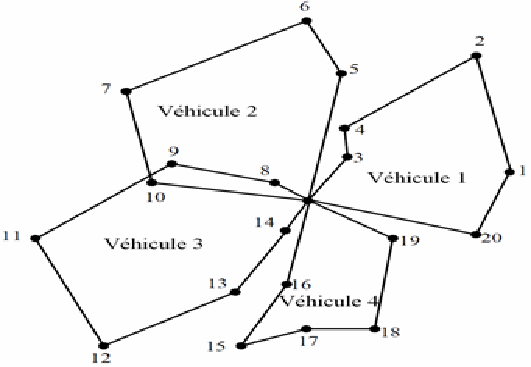

In [731]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [732]:
import pulp
import random

In [733]:
# definir des constraints

n = 18
nbvehicles = 3
n0 = {0}
nf = {n+1}

In [734]:
C = range(1, n + 1)  
V = range(1, nbvehicles + 1) 

**Paraméters**

* C : L'ensemble de l'emplacements . 
* K: L'ensemble de vehicules.
* cij : Cout du trajet entre l'emplacement i et l'emplacement j.
* di: la demande du client i.


In [735]:
# Générer des coûts/distances aléatoires entre les C emplacement
c = [[random.randint(0, 200) for j in C] for i in C]

# Générer des demandes aléatoires pour chaque ville
d = [random.randint(0, 100) for i in C]


In [736]:
#problem = pulp.LpProblem("Minimization Problem", pulp.LpMinimize)

In [737]:
# PuLP problem
problem = pulp.LpProblem("vrp", pulp.LpMinimize)

**Variables**

* xijk: Indique 1 si le vehicule k  visite l'emplacement j depuis l'emplacement i ou 0 sinon.
* xiik=0

In [738]:
x = pulp.LpVariable.dicts("x", (C, C, V),lowBound=0, upBound=1, cat='Binary')


In [739]:
cost = pulp.lpSum(c[i-1][j-1] *x[i][j][k] for i in C for j in C for k in V)
problem +=cost

Contraintes:
1. Contrainte: assure que chaque nœud est entré une fois par un vehicule. 
equation 3

$\sum_{k\in V}^{}\sum_{j\in{C} \cup \{ n+1\}}^{} x_{ijk}  \le 1, \forall i \in C$







In [740]:
# les contraintes
# contrainte 1
for j in C or j == nf:
    if j > 1:
        problem += pulp.lpSum(x[i][j][k] for i in C for k in V ) == 1

2. contrainte: assure la sortie de chaque vehicule est le point entré. 
equation 5

$\sum_{i\in{C} \cup\{ 0 \} }^{} x_{ijk}=  \sum_{j\in{C}\cup\{ n+1\} }^{} x_{jik},\forall k\in V$


In [741]:
# contrainte 2
for k in V:
        problem += pulp.lpSum(x[i][j][k] for i in C or i == n0) == pulp.lpSum(x[j][i][k] for i in C or j == nf)

3. contrainte:Chaque véhicule quitte le dépôt.
equation 4

$\sum_{j\in {C}\{ n+1 \} }^{} x_{0jk}= 1, \forall k\in V$

In [742]:
# contrainte 3
for j in C or j == nf:
  if j == 0:
    problem += pulp.lpSum(x[0][j][k] for k in V) == 1

4. contrainte: toujours un chemin unique et force exigeant.

$\sum_{j\in{C}\cup\{ 0 \} }^{} x_{i,n+1,k}= 1, \forall k\in V$

In [743]:
for j in C or j == n0: #
        problem +=pulp.lpSum(x[i][i][k] for i in C for k in V) == 1

$y_{i}$ temps de charge Total pendent la mission.​

$y_{i} = \sum_{j \in C \cup \{ n+1 \} }^{} \sum_{k \in V } X_{ijk}, \forall i \in C$

In [744]:
y = {}
for i in C :
    y[i] = sum(sum(x[i][j][k] for k in V) for j in C or j == nf )

  

In [745]:
#problem.solve()


In [746]:
#print("Objective Value:", pulp.value(problem.objective))
#for v in problem.variables():
    #print(v.name, "=", v.varValue)

* qk: la capacité du vehicule k.

In [747]:
# capacite du vehicules
#q = [random.randint(1, 1000) for k in V]

* trt :  reconnaisance de temps en min
* Vv : vitesse de MCV


les variable de constante de temps:
* $T^{S}_i$ : le temps de départ.
* $T^{SC}_i$ : charge heure de début.
* $T^{EC}_i$ : heure de fin de charge. 
* $T^{EN}_i$: heure de fin de l’UAV.

In [748]:
# T={}
# T_SC={}
# T_EC= {}
T_EN = {}

Equation : 9  calcule l'heure de début  de chaque événement de charge pour chaque UAV i de la mission.

$T^{S}_i =  \begin{cases}\  \text {0 },  \ tyi=1 \\  T^{EN}_i +trt , \ sinon \end{cases} , \forall i \in C$

In [749]:
T = {}

for i in C:
  if i in T_EN:
    if ti == 1:
        T[i] = 0
    else:
        T[i] = T_EN[i] + trt



* $P^{S}_i$ : le points debut

* $P^{SC}_i$ : points de départ du charge

* $P^{EN}_i$  : point fin

* $V^{}_u$ : Vitesse de l'UAV en Km/h

In [750]:
P_S = {}
P_SC = {}
P_EN = {}



Equation 10: calcule l'heure de départ du MCV (TiSC) pour atteindre l'UAV i.​

$T^{SC}_i =  |P^{S}_i - P^{SC}_i|/V_{u} , \forall i \in C$



In [751]:
T_SC={}
for i in C:
    if i in P_S and i in P_SC:
        dist = abs(P_S[i] - P_SC[i])
        T_SC[i] = dist / V_u
    else: 
      T_SC[i] = None

Equation 11:  l'heure de fin de l'événement de charge 

$T^{EC}_i =   T^{SC}_i +t_i , \forall i \in C $

$t_i$ :  est temps de charge sur le bord 

In [752]:
T_EC = {}  

for i in C:
    if i in T_SC and i in T_EC:
      #ti = 0
        T_EC[i] = T_SC[i] # + ti  
    

Equation 12: calcule l'heure de fin du MCV (TiEN) après que celui-ci a chargé l'UAV i​

$T^{EN}_i =   T^{S}_i +\left| P^{S} - P^{EN} \right|/V_{u} + (t_{i} + \frac{v_{v}t_{i}}{v_{u}})y_{i} , \forall i \in C $

* $V^{}_u$ : Vitesse de l'UAV en 132 Km/h 
* $V^{}_v$ : Vitesse de MCV en 90 Km/h 

In [753]:
for i in C:
  for i in T:
    for i in P_S and i in P_EN:
      dist = abs(P_S - P_EN)
      S = (t_i + (V_v * t_i) / V_u) * y[i]
      T_EN[i] = T[i] + (dist / V_u) + S

Equation 13:

$P^{SC}_i =  l_{i}\left( P^{EN}_i - P^{S}_i  \right) + P^{S}_i , \forall i \in C$


* $l_{i}$ : le taux de charge  avec  $0\lt li\lt  1, \forall i \in C $

In [754]:
for i in C: 
  for i in P_S and i in P_EN:
   if 0 < li < 1:
    P_SC[i] = li*(P_EN[i] - P_S[i]) + P_S[i]

Equation 14:

$P^{EC}_i =  \frac{\left( P^{EN}_i - P^{S}_i  \right)}{\left| P^{S}_i - P^{EN}_i\right|} +  \left( v_{v}t_{i} + \left| P^{S}_i - P^{SC}_i \right|\right) + P^{S}_i, \forall i \in C $

In [755]:
P_EC ={}
for i in C: 
  if i in P_S and i in P_SC and i in P_EN:
    point = (P_EN[i] - P_S[i])
    dist1 = abs(P_S[i] - P_EN[i])
    dist2 = abs(P_S[i] - P_SC[i])
    P_EC[i] = point/dist1 + (V_v*t_i + dist2) + P_S[i]

Equations 15 ,16 indiquent que les emplacements de charge ne peuvent pas être dans la reconnaissance zones.

${\left| P^{S}_i - P^{SC}_i\right|}\ge R_{rt}.y_{i},\forall i \in
 C,$ (15)


${\left| P^{EN}_i - P^{EC}_i\right|}\ge R_{rt}.y_{i},\forall i \in C$ (16)

* $R_{rt}$ : reconnaissance radius en 5km




In [756]:
for i in C: 
  if i in P_S and i in P_SC : # 15
    dist = abs(P_S[i] - P_SC[i])
    dist >= (R_rt * y)
  if i in P_EN and i and P_EC : 
    dist1 = abs(P_EN[i] - P_EC[i])
    dist1 >= (R_rt * y)

Equation 18:

$T^{EC}_i + \frac{\left| P^{EC}_i - P^{EC}_j  \right|}{v_{v}} + K(1-x_{ijk})\le T^{SC}_i,
\forall i,j \in C, \forall k \in V$ 

avec $K$ constante

In [757]:
for i in C:
    for j in C:
        if i != j:
            for k in V:
                if i in T_EC and j in T_EC and i in P_EC and j in P_EC:
                    if T_EC[i] + abs(P_EC[i] - P_EC[j]) / V_v + K * (1 - x[i][j][k]) <= T_SC[i]:
                      pass

Contraintes liées au capacite
* $Q^{S}_i$ : la capacité de la batterie de l’UAV au début,
* $Q^{SC}_i$: temps de début de charge,
* $Q^{EC}_i$: heure de fin de charge,
* $Q^{EN}_i$ : temps de fin sur le bord i


In [758]:
Q_S = {}
Q_SC = {}
Q_EC = {}
Q_EN = {}


Equation 19: capacité de la batterie de l'UAV lorsqu'il commence sa mission




$Q^{S}_i =  \begin{cases}\  \text Q_{max} ,  \ tyi=1 \\  Q^{EN}_{i-1}  , \ sinon \end{cases} , \forall i \in C$

In [759]:
for i in C:
  
  if ti == 1:
        Q_S[i] = Q_max
  else:
        if i - 1 in Q_EN:
            Q_S[i] = Q_EN[i - 1]

Equation 20: la capacité de la batterie après avoir chargé .

$Q^{SC}_i =  Q^{S}_i + \left| P^{S}_i- P^{SC}_i \right|\mu_{u}/v_{u},\forall i \in C$

* $\mu_{u}$ : taux de consommation d’énergie en vol des UAV  en KW


In [760]:
U_u = 60

In [761]:
for i in C:
  if i in Q_S and i in P_S and i in P_SC:
    dist = abs(P_S[i] - P_SC[i])
    Q_SC[i] = Q_S[i] + dist * (U_u * V_v)

Equation 21: Capacite de la batterie une fois terminer la charge​

$Q^{EC}_i =  Q^{S}_i +\mu_{c}t_{i},\forall i \in C$

* $\mu_{c}$ :puissance de charge en Kw.

In [762]:
U_c = 60

In [763]:
for i in C:
  if i in Q_S:
    Q_EC[i] = Q_S[i] + (U_u * ti)

Equation 22: Temps de fin charge batterie​

$Q^{EN}_i =  Q^{S}_i - \frac{\left| P^{S}_i - P^{EN}_i \right|}{v_{v}}\mu_{u} + \left( \mu_{c}ti -\frac{v_{v}ti}{v_{u}}\mu_{u} \right).y_{i},\forall i \in C$

In [764]:
for i in C:
  if i in Q_S and i in P_S and i in P_EN :
    dist = abs(P_S[i] - P_EN[i])/V_v
    A = ((V_v*ti)/V_u)*U_u
    B = (U_c*ti)
    Q_EN[i] = Q_S[i] - (dist*U_u) + (B-A)*y
    

* $y_{i}$ temps de charge Total pendent la mission.​

Equation 23:  Capacite de la batterie une fois terminer la charge​

$Q^{EC}_i \le Q_{max} +K(1 - yi) , \forall i \in C$

* $Q_{max}$ : capacite maximum de la batterie
* $Q_{min}$ : capacite minimum de la baterie

In [765]:
for i in C:
  if i in Q_EC:
     Q_EC[i] <= Q_max + K * (1 - y)
      

Equation 24: capacite de batterie au début de la mission

$Q^{SC}_i \ge  Q_{min} +K(1 - yi) , \forall i \in C$

In [766]:
for i in C:
  if i in Q_SC:
     Q_SC[i] >= Q_min + K * (1 - y)
      

Equation 25:  capacite de batterie au début de temps

$Q^{S}_i \ge  Q_{min}  , \forall i \in C$

In [767]:
for i in C:
  if i in Q_S:
     Q_S[i] >= Q_min

Equation 26:  Temps de fin charge batterie​

$Q^{EN}_i \ge  Q_{min}  , \forall i \in C$

In [768]:
for i in C:
  if i in Q_EN:
     Q_EN[i] >= Q_min

Objectif -optimization

Equation : Multi objectif

$C=C_{r}+C_{c}+ C_{u} $

Variables: 

* $C$ : le cout

* $C_{r}$ : cout route .

* $C_{c}$ : cout charge .

* $C_{u}$ :  Cout Utilisation 


$P_{B}$ : est la coordonnée du point de base.

$L_{k} = \sum_{j \in C}^{}x_{0jk} \left| P^{B} - P^{SC}_{i} \right| + \sum_{i \in C}^{}x_{i,n+1,k} \left| P^{B} - P^{EC}_{i} \right| + \sum_{i,j \in C}^{}x_{ijk} \left| P^{EC}_{i} - P^{EC}_{j} \right|
+ \sum_{i\in C}^{}\left(  v_{v}t_{i} \sum_{j\in C\cup\left\{n+1 \right\}}^{} x_{ijk}\right)
\\ \forall k \in V$

In [769]:
# equation ordre (1)
#for j in C:
 #  if i in P_SC:
 #   dist = abs(P_B - P_SC[i])
  #  E1=pulp.lpSum(x[o][j][k] * dist)

# equation   ordre 2 
#for i in C: 
 # if i in P_EC:
    #dist1= abs(P_B - P_EC[i])
    #E2= pulp.lpSum(x[i][nf][k] * dist1) 

# equation ordre (3)
#for i in C:
  #for j in C: 
   # if i in P_EC and j in P_EC : 
    #  dist = abs(P_EC[i] - P_EC[j])
    #  E3= pulp.lpSum(x[i][j][k] *dist )

# equation ordre 4
#for i in C: 
  #for j in C or j == nf:
   # E4= pulp.lpSum(x[i][j][k] * (V_v*ti))

#l_k = {}
#for k in V:
#  for i in C:
#    for j in C:
 #     l_k =E1+E2+E3+E4 

In [770]:
# chatgpt
import numpy as np

def calculate_Lk(x, P_B, P_SC, P_EC, v_v, t):
    C = range(len(P_SC))  # Assuming C represents a set of indices
    Lk = 0
    # 1 summation
    for j in C:
        Lk += x[0, j, k] * np.abs(P_B - P_SC[j])
    # 2 summation
    for i in C:
        Lk += x[i, nf, k] * np.abs(P_B - P_EC[i])
    
    # 3 summation
    for i in C:
        for j in C:
            Lk += x[i, j, k] * np.abs(P_EC[i] - P_EC[j])
    
    # 4 summation
    for i in C:
        sum_xijk = np.sum(x[i, :, k])
        Lk += V_v * t[i] * sum_xijk
    
    return Lk

#Lk = calculate_Lk(x, P_B, P_SC, P_EC, v_v, t)
#print(Lk)


$C_{r} = \sum_{k\in V}^{}\left( L_{k}/v_{v} \right)\mu_{v}P$

avec p : prix de l'électricité

In [771]:
#for k in V:
  # Cr = (Lk/V_v)*(U_v*P)

def calculate_Cr(V, L, V_v, U_v, P):
    Cr = 0
    for k in V:
        Cr += (Lk[k] / V_v) * U_v[k] * P
    return Cr

$C_{c} = \sum_{k\in V}^{}y_{i}t_{i}\mu_{c}P$

In [772]:
def calculate_Cc(V, ti, U_c, P):
    Cr = 0
    for k in V:
        Cc += (y*ti*U_c*p)
    return Cc

$C_{u} = p_{u}\sum_{k\in V}^{}\sum_{j \in C}^{}x_{0jk}$

* $P_{u}$ :le coût d’utilisation unitaire.

In [773]:
def calculate_Cu(V,C,x,Pu):
  Cu=0
  for k in V:
    for j in C:
      Cu += Pu * x[0][j][k]
    return Cu


$C=C_{r}+C_{c}+ C_{u} $


In [774]:
result = lambda l : calculate_Cc()+calculate_Cr()+calculate_Cu()
Ct = result

Equation 32

$a_{i} = T^{EN,0}_{i} +K(1-tyi)tyi,\forall i \in C$

$a_{i}$ :  sont les limites inférieures 

$T^{EN,0}_{i}$ : heure d’arrivée de la cible sans envisager de charge. 


In [775]:
# 32:
a ={}
T_EN_0 = {}
for i in C:
  for i in T_EN_0:
    a[i] = T_EN_0[i] - (k*(1-ti)*ti)


Equation(33):

$b_{i}= a_{i} + \lambda T^{EN,0}_{i} - K(1-tyi)tyi, \forall i \in C$


$b_{i} $ :  sont les limites  supérieures du temps
fenêtre au point final du bord i



In [776]:
b={}
for i in C:
  for i in a and i in T_EN_0:
    b[i] = a[i] + landa*T_EN_0[i] - (k*(1-ti)*ti)

Equation 34: 

$D = \sum_{i \in C}^{} \left( T^{EN}_{i} - b_{i} \right)$

$D$: la fenêtre horaire de la mission de reconnaissance
déviation

In [777]:

for i in C:
  for i in T_EN and i in b:
    problem+= pulp.lpSum(T_EN[i] - b[i])
    #D= problem

In [778]:
problem.solve()


1

In [779]:
#from scipy.optimize import minimize

In [780]:
print("Objective Value:", pulp.value(problem.objective))
#for v in problem.variables():
 #   print(v.name, "=", v.varValue)


Objective Value: 135.0


*fonction objective *